# 1. Instalar bibliotecas Necessárias

In [ ]:
!pip install tensorflow opencv-python matplotlib

In [ ]:
!pip list

In [1]:
import tensorflow as tf
import os

# 2. Tratar imagens

In [ ]:
#Script para converter imagens jpg para jpeg
import os
from PIL import Image

data_dir = 'data'

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            if image.endswith('.jpg'):
            
                img = Image.open(image_path)
                
            
                new_image_path = os.path.splitext(image_path)[0] + '.jpeg'
                
               
                img.save(new_image_path, 'JPEG')
                
                print('Converted file: {} to {}'.format(image_path, new_image_path))
                
             
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

In [ ]:
import cv2
import imghdr

In [ ]:
data_dir = 'data' 

In [ ]:
image_exts = ['jpeg','JPG', 'bmp', 'png']

In [ ]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Injetar imagens

In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 1647 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

In [14]:
# 0 -> Cancer de pele
# 1 -> Acne
batch[1]

array([1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1])

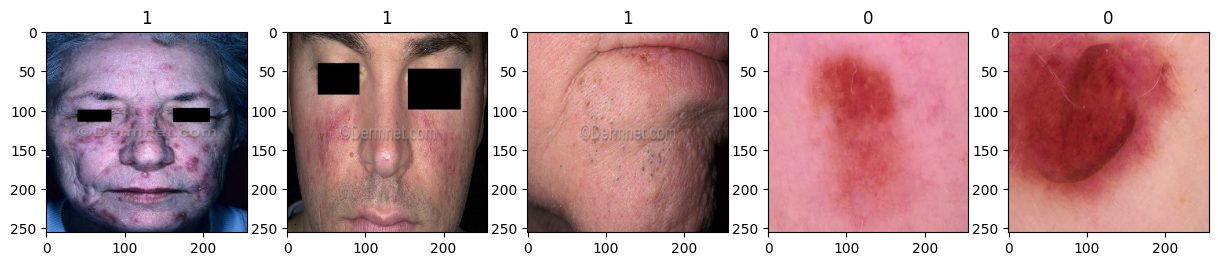

In [15]:
fig, ax = plt.subplots(ncols=5, figsize=(15,15))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Diminuir tamanho das cores da imagem 


In [16]:
data = data.map(lambda x,y: (x/255, y))

In [17]:
data.as_numpy_iterator().next()

(array([[[[8.16973031e-01, 5.18933833e-01, 5.34620106e-01],
          [8.10302019e-01, 5.12262821e-01, 5.27949095e-01],
          [8.20065260e-01, 5.22026002e-01, 5.34893692e-01],
          ...,
          [8.57186615e-01, 5.94441473e-01, 6.21892452e-01],
          [8.48544717e-01, 5.85799634e-01, 6.13250613e-01],
          [8.60421956e-01, 5.97676814e-01, 6.25127792e-01]],
 
         [[8.12515318e-01, 5.10554552e-01, 5.34083962e-01],
          [8.03974450e-01, 5.05935252e-01, 5.21621525e-01],
          [8.14047158e-01, 5.16007960e-01, 5.28875589e-01],
          ...,
          [8.50787699e-01, 5.88042617e-01, 6.15493596e-01],
          [8.51516545e-01, 5.88771462e-01, 6.16222441e-01],
          [8.54365826e-01, 5.91620684e-01, 6.19071662e-01]],
 
         [[8.09129894e-01, 5.07169127e-01, 5.30698538e-01],
          [8.03921580e-01, 5.02429187e-01, 5.25021791e-01],
          [8.10661793e-01, 5.12622535e-01, 5.28011560e-01],
          ...,
          [8.49571049e-01, 5.86825967e-01, 6.1427

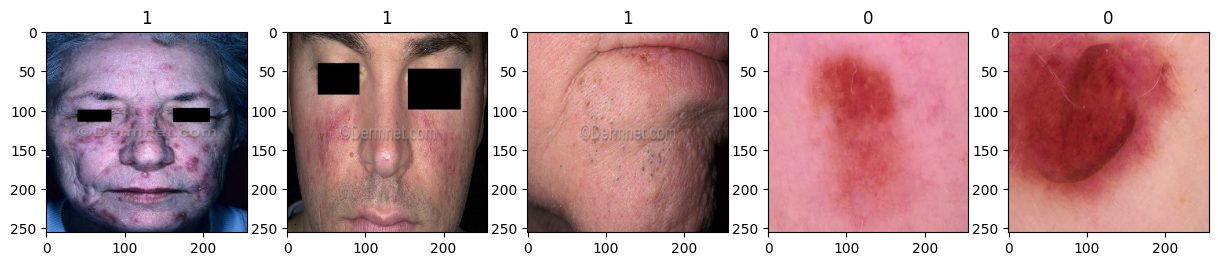

In [18]:
fig, ax = plt.subplots(ncols=5, figsize=(15,15))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 5. Dividir imagens para treinamento, validação e teste

In [19]:
len(data)

52

In [20]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [21]:
test_size

5

In [22]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Criar o modelo de aprendizagem


In [23]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2

In [25]:
model = Sequential()

In [26]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3), kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(32, (3,3), 1, activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(16, (3,3), 1, activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [27]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 32)        0

# 7. Treinamento


In [29]:
logdir='logs'

In [30]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [31]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40
36/36 [==============================] - 24s 635ms/step - loss: 3.3583 - accuracy: 0.6623 - val_loss: 1.8049 - val_accuracy: 0.7531
Epoch 2/40
36/36 [==============================] - 23s 626ms/step - loss: 1.3243 - accuracy: 0.8377 - val_loss: 0.9874 - val_accuracy: 0.9250
Epoch 3/40
36/36 [==============================] - 24s 659ms/step - loss: 0.8690 - accuracy: 0.8689 - val_loss: 0.7870 - val_accuracy: 0.9031
Epoch 4/40
36/36 [==============================] - 24s 658ms/step - loss: 0.6930 - accuracy: 0.8793 - val_loss: 0.6843 - val_accuracy: 0.8750
Epoch 5/40
36/36 [==============================] - 24s 658ms/step - loss: 0.6301 - accuracy: 0.8845 - val_loss: 0.6039 - val_accuracy: 0.8844
Epoch 6/40
36/36 [==============================] - 24s 666ms/step - loss: 0.5292 - accuracy: 0.9193 - val_loss: 0.4900 - val_accuracy: 0.9438
Epoch 7/40
36/36 [==============================] - 24s 656ms/step - loss: 0.5006 - accuracy: 0.9115 - val_loss: 0.5066 - val_accuracy: 0.9094

# 8. Exibição de graficos de performance

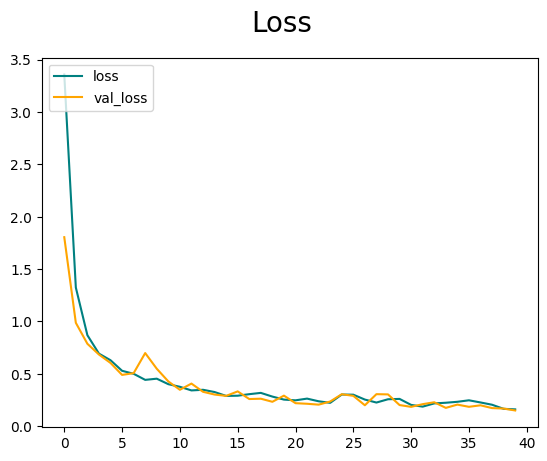

In [83]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

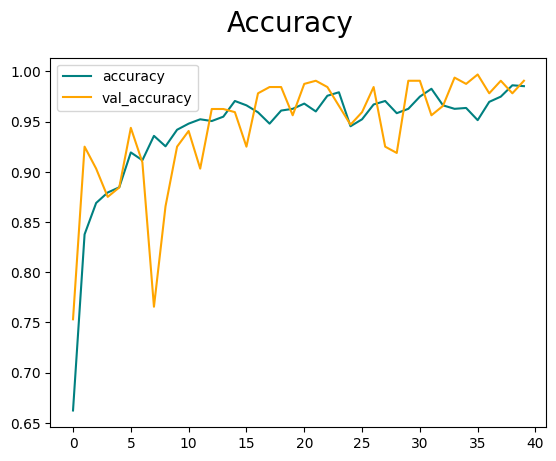

In [84]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Avaliação de performance


In [85]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [86]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [87]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 156ms/step


In [88]:
print(pre.result().numpy(), re.result().numpy(), acc.result().numpy())

1.0 1.0 1.0


# 10. Teste com imagens


In [89]:
import cv2

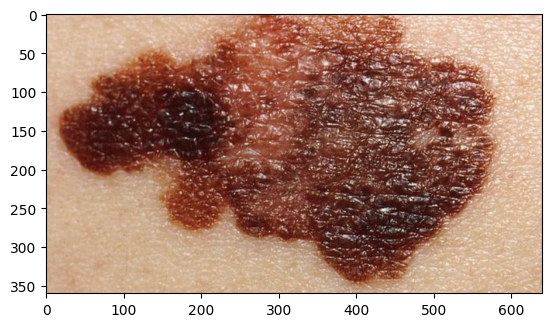

In [107]:
img = cv2.imread('cancerEx2.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

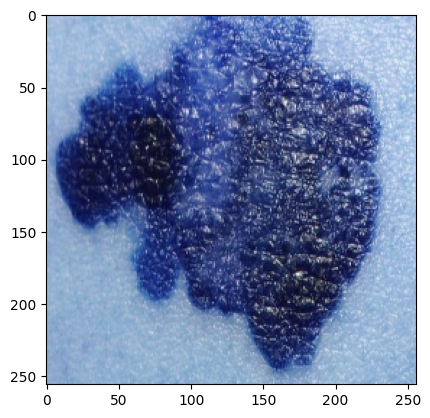

In [108]:
resize = tf.image.resize(img, (256,256))
plt.imshow( resize.numpy().astype(int))
plt.show()

In [109]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 34ms/step


In [110]:
yhat

array([[0.9894817]], dtype=float32)

In [111]:
if yhat > 0.5: 
    print(f'Predicted class is acne or rosacea')
else:
    print(f'Predicted class is cancer')

Predicted class is acne or rosacea
